# Var Implementation
This notebook walks through our Vector Auto Regression implementation as contained in the var_module.py module. 

In [1]:
import var_module as var
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc3 as pm
import graphviz
import arviz as az
import seaborn as sns
from scipy.stats import norm
import copy

## Intialize our custom parameters
Predictors must match available columns exactly. City must match an available city exactly

In [2]:
filename = 'formatted_data.csv'
df = pd.read_csv(filename)

In [3]:
city = "Atlanta"
order = 5
predictors = [
              'hourly_earnings',
              'unemployment_rate',
              'leisure',
              'housing_median_days_on_market',
              'housing_median_listing_price'
]
key_var = 'housing_median_listing_price'

seasonal_vars = [col for col in df.columns if '_s0' in col and col.split("_s0")[0] in predictors]
seasonal_vars

['housing_median_listing_price_s0', 'housing_median_days_on_market_s0']

## Initialize & Preprocess data
Ingest the raw data and generate the ouptut data frame with specified predictors

In [4]:
df = pd.read_csv(filename).query(f"city == '{city}'")
df = df.query("year < 2020")
df = df.dropna()
df.insert(3, 'year_month', df.year + df.month/100)
df = df.drop(columns = ['date','year','month','state']).reset_index(drop=True)
if city == 'Tulsa':
    df = df.loc[15:].reset_index(drop=True)
df.head()

,year_month,city,housing_median_listing_price,housing_active_listing_count,hourly_earnings,unemployment_rate,financial,housing_new_listing_count,leisure,housing_median_days_on_market,manufacturing,education,housing_median_home_size_in_square_feet,government,resident_population,housing_active_listing_count_4,hourly_earnings_4,unemployment_rate_4,financial_4,housing_new_listing_count_4,leisure_4,housing_median_days_on_market_4,manufacturing_4,education_4,housing_median_home_size_in_square_feet_4,housing_median_listing_price_4,government_4,housing_active_listing_count_3,hourly_earnings_3,unemployment_rate_3,financial_3,housing_new_listing_count_3,leisure_3,housing_median_days_on_market_3,manufacturing_3,education_3,housing_median_home_size_in_square_feet_3,housing_median_listing_price_3,government_3,housing_active_listing_count_2,...,unemployment_rate_2,financial_2,housing_new_listing_count_2,leisure_2,housing_median_days_on_market_2,manufacturing_2,education_2,housing_median_home_size_in_square_feet_2,housing_median_listing_price_2,government_2,housing_active_listing_count_1,hourly_earnings_1,unemployment_rate_1,financial_1,housing_new_listing_count_1,leisure_1,housing_median_days_on_market_1,manufacturing_1,education_1,housing_median_home_size_in_square_feet_1,housing_median_listing_price_1,government_1,housing_active_listing_count_0,hourly_earnings_0,unemployment_rate_0,financial_0,housing_new_listing_count_0,leisure_0,housing_median_days_on_market_0,manufacturing_0,education_0,housing_median_home_size_in_square_feet_0,housing_median_listing_price_0,government_0,housing_median_listing_price_s0,housing_active_listing_count_s0,housing_new_listing_count_s0,housing_median_days_on_market_s0,housing_median_home_size_in_square_feet_s0,resident_population_0
0,2017.07,Atlanta,297984.0,35046,28.044351,4.5,169.896262,14776,290.896371,51.0,164.860193,345.437579,2624.0,329.227326,5876.763,33715.0,27.784923,4.6,170.028819,14912.0,291.109802,47.0,164.427838,345.004540,2666.0,299900.0,330.217308,32540.0,27.783741,4.7,169.167906,16028.0,289.993664,45.5,163.827382,343.988814,2653.5,299900.0,328.741049,30725.0,...,4.8,168.376978,14924.0,289.240655,45.0,163.604016,343.157706,2623.0,297000.0,328.939399,30289.0,27.633633,4.9,168.096746,15320.0,287.275921,45.5,165.207926,342.543976,2552.5,282450.0,328.931550,31614.0,27.571531,5.0,167.435650,13496.0,286.474766,53.5,164.406358,340.981063,2512.5,274750.0,328.406074,272000.0,42224.0,14848.0,50.0,2558.0,5791.874
1,2017.08,Atlanta,299900.0,42319,27.930131,4.4,170.132973,16868,292.559627,51.0,165.167667,346.246361,2623.5,328.565085,5876.763,35046.0,28.044351,4.5,169.896262,14776.0,290.896371,51.0,164.860193,345.437579,2624.0,297984.0,329.227326,33715.0,27.784923,4.6,170.028819,14912.0,291.109802,47.0,164.427838,345.004540,2666.0,299900.0,330.217308,32540.0,...,4.7,169.167906,16028.0,289.993664,45.5,163.827382,343.988814,2653.5,299900.0,328.741049,30725.0,28.118751,4.8,168.376978,14924.0,289.240655,45.0,163.604016,343.157706,2623.0,297000.0,328.939399,30289.0,27.633633,4.9,168.096746,15320.0,287.275921,45.5,165.207926,342.543976,2552.5,282450.0,328.931550,269900.0,40038.0,13340.0,52.5,2540.5,5791.874
2,2017.09,Atlanta,299900.0,41215,28.309721,4.4,170.749323,15132,291.888840,57.0,165.190036,347.071555,2610.0,330.814137,5876.763,42319.0,27.930131,4.4,170.132973,16868.0,292.559627,51.0,165.167667,346.246361,2623.5,299900.0,328.565085,35046.0,28.044351,4.5,169.896262,14776.0,290.896371,51.0,164.860193,345.437579,2624.0,297984.0,329.227326,33715.0,...,4.6,170.028819,14912.0,291.109802,47.0,164.427838,345.004540,2666.0,299900.0,330.217308,32540.0,27.783741,4.7,169.167906,16028.0,289.993664,45.5,163.827382,343.988814,2653.5,299900.0,328.741049,30725.0,28.118751,4.8,168.376978,14924.0,289.240655,45.0,163.604016,343.157706,2623.0,297000.0,328.939399,270168.0,39473.0,13404.0,54.0,2534.0,5791.874
3,2017.10,Atlanta,299900.0,39972,28.398512,4.3,171.222727,14652,295.897665,58.0,165.633540,347.195193,2600.0,330.660474,587

In [5]:
base_cols = ['year_month','city']
drop_cols = []

for pred in predictors:
    for col in list(df.columns):
        if pred in col:
            base_cols.append(col)
df = df[base_cols].reset_index(drop=True)
df = df.rename({'city':'city_'}, axis=1)
input_df = df.reset_index(drop=True)
input_df.head(10)

,year_month,city_,hourly_earnings,hourly_earnings_4,hourly_earnings_3,hourly_earnings_2,hourly_earnings_1,hourly_earnings_0,unemployment_rate,unemployment_rate_4,unemployment_rate_3,unemployment_rate_2,unemployment_rate_1,unemployment_rate_0,leisure,leisure_4,leisure_3,leisure_2,leisure_1,leisure_0,housing_median_days_on_market,housing_median_days_on_market_4,housing_median_days_on_market_3,housing_median_days_on_market_2,housing_median_days_on_market_1,housing_median_days_on_market_0,housing_median_days_on_market_s0,housing_median_listing_price,housing_median_listing_price_4,housing_median_listing_price_3,housing_median_listing_price_2,housing_median_listing_price_1,housing_median_listing_price_0,housing_median_listing_price_s0
0,2017.07,Atlanta,28.044351,27.784923,27.783741,28.118751,27.633633,27.571531,4.5,4.6,4.7,4.8,4.9,5.0,290.896371,291.109802,289.993664,289.240655,287.275921,286.474766,51.0,47.0,45.5,45.0,45.5,53.5,50.0,297984.0,299900.0,299900.0,297000.0,282450.0,274750.0,272000.0
1,2017.08,Atlanta,27.930131,28.044351,27.784923,27.783741,28.118751,27.633633,4.4,4.5,4.6,4.7,4.8,4.9,292.559627,290.896371,291.109802,289.993664,289.240655,287.275921,51.0,51.0,47.0,45.5,45.0,45.5,52.5,299900.0,297984.0,299900.0,299900.0,297000.0,282450.0,269900.0
2,2017.09,Atlanta,28.309721,27.930131,28.044351,27.784923,27.783741,28.118751,4.4,4.4,4.5,4.6,4.7,4.8,291.888840,292.559627,290.896371,291.109802,289.993664,289.240655,57.0,51.0,51.0,47.0,45.5,45.0,54.0,299900.0,299900.0,297984.0,299900.0,299900.0,297000.0,270168.0
3,2017.10,Atlanta,28.398512,28.309721,27.930131,28.044351,27.784923,27.783741,4.3,4.4,4.4,4.5,4.6,4.7,295.897665,291.888840,292.559627,290.896371,291.109802,289.993664,58.0,57.0,51.0,51.0,47.0,45.5,54.0,299900.0,299900.0,299900.0,297984.0,299900.0,299900.0,269900.0
4,2017.11,Atlanta,28.108369,28.398512,28.309721,27.930131,28.044351,27.784923,4.3,4.3,4.4,4.4,4.5,4.6,295.263592,295.897665,291.888840,292.559627,290.896371,291.109802,58.0,58.0,57.0,51.0,51.0,47.0,56.5,299950.0,299900.0,299900.0,299900.0,297984.0,299900.0,269900.0
5,2017.12,Atlanta,28.432347,28.108369,28.398512,28.309721,27.930131,28.044351,4.2,4.3,4.3,4.4,4.4,4.5,294.256540,295.263592,295.897665,291.888840,292.559627,290.896371,65.0,58.0,58.0,57.0,51.0,51.0,66.0,300000.0,299950.0,299900.0,299900.0,299900.0,297984.0,269000.0
6,2018.01,Atlanta,28.534464,28.432347,28.108369,28.398512,28.309721,27.930131,4.2,4.2,4.3,4.3,4.4,4.4,295.047158,294.256540,295.263592,295.897665,291.888840,292.559627,68.0,65.0,58.0,58.0,57.0,51.0,67.5,306950.0,300000.0,299950.0,299900.0,299900.0,299900.0,269900.0
7,2018.02,Atlanta,28.784818,28.534464,28.432347,28.108369,28.398512,28.309721,4.2,4.2,4.2,4.3,4.3,4.4,295.135118,295.047158,294.256540,295.263592,295.897665,291.888840,54.0,68.0,65.0,58.0,58.0,57.0,53.5,312450.0,306950.0,300000.0,299950.0,299900.0,299900.0,274750.0
8,2018.03,Atlanta,28.793932,28.784818,28.534464,28.432347,28.108369,28.398512,4.1,4.2,4.2,4.2,4.3,4.3,296.789175,295.135118,295.047158,294.256540,295.263592,295.897665,43.0,54.0,68.0,65.0,58.0,58.0,45.5,324900.0,312450.0,306950.0,300000.0,299950.0,299900.0,282450.0
9,2018.04,Atlanta,29.347790,28.793932,28.784818,28.534464,28.432347,28.108369,4.0,4.1,4.2,4.2,4.2,4.3,296.076983,296.789175,295.135118,295.047158,294.256540,295.263592,44.0,43.0,54.0,68.0,65.0,58.0,45.0,337000.0,324900.0,312450.0,306950.0,300000.0,299950.0,297000.0


## Generate pymc3 Model
This will write a python script needed to generate a pymc3 model using our predictors that will be used for variational inference.

In [6]:
var.write_model_module(input_df=input_df, key_var=key_var, seasonal_vars=seasonal_vars)

import model_builder
model_comb = model_builder.build_model(input_df=input_df)

In [7]:
pm.model_to_graphviz(model_comb)

## Generate posterior predictions for our coefficients
This utilizes ADVI implementation of variational inference in pymc3 to generate our posterior predictions (this can take a few minutes)

In [8]:
parameters = var.generate_advi_posterior(model_comb)
parameters

Finished [100%]: Average Loss = 1,263.5


,variable,mean,std
0,sigma_hourly_earnings_log__,-1.148,0.14918
1,intercept_hourly_earnings,0.329,0.06425
2,hourly_earnings_4_hourly_earnings,0.222,0.00219
3,hourly_earnings_3_hourly_earnings,0.206,0.00229
4,hourly_earnings_2_hourly_earnings,0.222,0.00225
...,...,...,...
58,sigma_hourly_earnings,0.321,0.04807
59,sigma_unemployment_rate,0.082,0.01211
60,sigma_leisure,2.007,0.30225
61,sigma_housing_median_days_on_market,3.164,0.46904


# Run the forward model 
input the starting time period (formatted yyyy.mm) and the number of steps that you want to advance in your predictions. This will deliver a dataframe with your posterior predictions for however many steps you want to project to. The standard deviation dataframe gives you the spread of each of the predictions.Below is the output for our mean prediction at each month

In [9]:
mean_df, std_df = var.run_projections(order=order, input=input_df, start_year_month=2018.12, samples=1000000, steps=12, parameters=parameters, key_var=key_var, seasonal_vars=seasonal_vars)
mean_df

,city_,year,month,day,date,year_month,housing_median_listing_price_4
0,Atlanta,2019,1,1,2019-01-01,2019.01,315113.59
1,Atlanta,2019,2,1,2019-02-01,2019.02,315218.42
2,Atlanta,2019,3,1,2019-03-01,2019.03,316009.63
3,Atlanta,2019,4,1,2019-04-01,2019.04,318416.23
4,Atlanta,2019,5,1,2019-05-01,2019.05,321809.90
5,Atlanta,2019,6,1,2019-06-01,2019.06,325077.62
6,Atlanta,2019,7,1,2019-07-01,2019.07,327843.29
7,Atlanta,2019,8,1,2019-08-01,2019.08,329153.21
8,Atlanta,2019,9,1,2019-09-01,2019.09,329873.77
9,Atlanta,2019,10,1,2019-10-01,2019.10,330605.89


Below is a is the dataframe showing the standard deviations for each of our predictions

In [10]:
std_df

,city_,year,month,day,date,year_month,housing_median_listing_price_4
0,Atlanta,2019,1,1,2019-01-01,2019.01,5945.96
1,Atlanta,2019,2,1,2019-02-01,2019.02,6941.04
2,Atlanta,2019,3,1,2019-03-01,2019.03,7441.29
3,Atlanta,2019,4,1,2019-04-01,2019.04,7705.32
4,Atlanta,2019,5,1,2019-05-01,2019.05,7849.67
5,Atlanta,2019,6,1,2019-06-01,2019.06,7924.90
6,Atlanta,2019,7,1,2019-07-01,2019.07,7944.36
7,Atlanta,2019,8,1,2019-08-01,2019.08,7947.51
8,Atlanta,2019,9,1,2019-09-01,2019.09,7941.63
9,Atlanta,2019,10,1,2019-10-01,2019.10,7962.00


# Visualize

In [11]:
# This scripts gets us a dataframe with our credible 95% intervals for the housing price projections
temp = pd.merge(left=mean_df, right=std_df[['date','housing_median_listing_price_4']].rename({'housing_median_listing_price_4':'std'}, axis=1), on = 'date', how= 'left').rename({'housing_median_listing_price_4':'housing_median_listing_price'}, axis=1)

new_dates = []
new_prices = []
for i in range(len(temp)):
    mean = temp.housing_median_listing_price.loc[i]
    std = temp['std'].loc[i]
    for u in range(3):
        new_dates.append(temp.date.loc[i])

        if u == 0:
            new_prices.append(mean+(1.96*std))
        elif u == 1:
            new_prices.append(mean-(1.96*std))
        else:
            new_prices.append(mean)

intervals = pd.DataFrame({
    "date":new_dates,
    "housing_median_listing_price":new_prices,
    'actual_prediction':'prediction'
})

Here we concatenate our predictions with the existing data to gauge the effectiveness of our predictions

In [12]:
start_year = 2018

new_input = copy.deepcopy(input_df)

new_input.insert(
    1, "year", (round(new_input.year_month - (new_input.year_month % 1), 0)).astype(int)
)
new_input.insert(2, "month", round(new_input.year_month % 1 * 100, 0).astype(int))
new_input.insert(3, "day", 1)
new_input.insert(4, "date", pd.to_datetime(new_input[["year", "month", "day"]]))
new_input = new_input[['city_','year','month','date','year_month','housing_median_listing_price']]
new_input = new_input.query(f"year >= {start_year}")
new_input['actual_prediction'] = 'actual'

df_line = pd.concat([new_input, intervals]).reset_index(drop=True)

Text(0.5, 1.0, 'Actual Housing Market v Model Prediction for Atlanta')

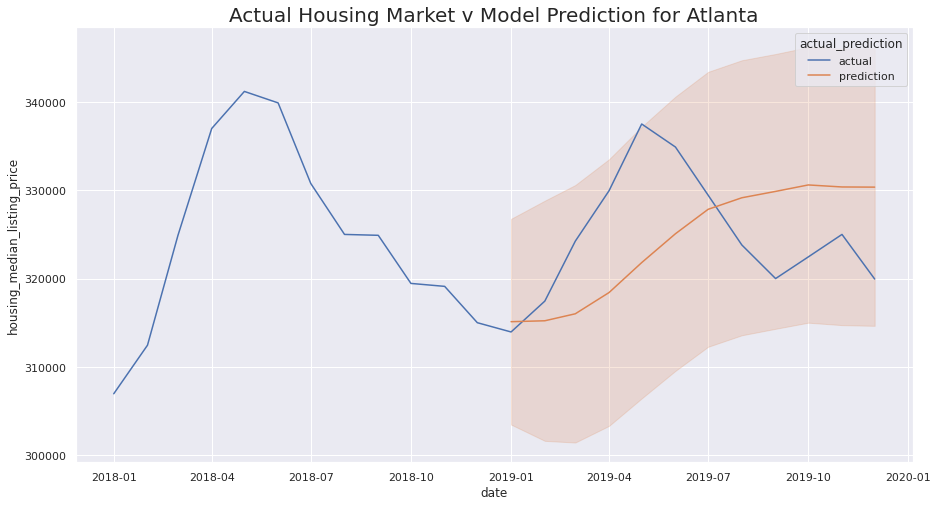

In [13]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.lineplot(data=df_line, x='date',y='housing_median_listing_price', hue='actual_prediction').set_title(f"Actual Housing Market v Model Prediction for {city}", fontsize = 20)

Here we illustrate the propagation of uncertainty in our predictions

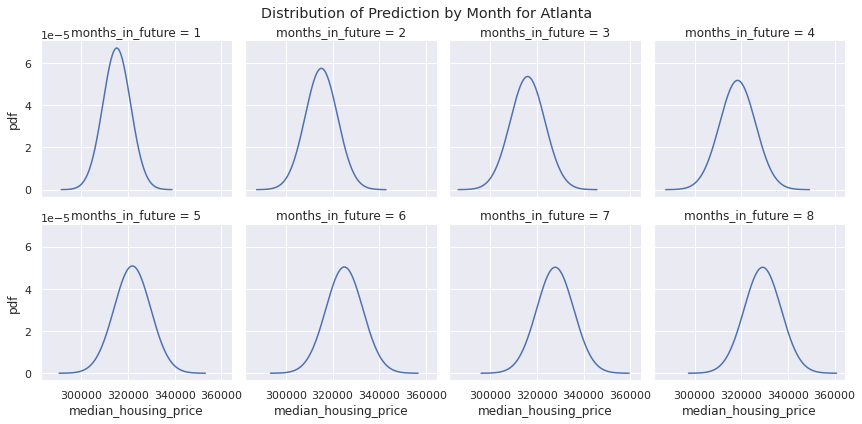

In [14]:
def plot_uncertainty(mean_df, std_df, steps):

    xs = []
    ys = []
    dists = []
    for dist in range(steps):
        mean = mean_df.housing_median_listing_price_4.loc[dist]
        std = std_df.housing_median_listing_price_4.loc[dist]
        new_xs = np.arange(-4 * std + mean, 4 * std + mean, 100)
        xs.extend(new_xs)
        ys.extend(norm.pdf(new_xs, mean, std))
        dists.extend([dist + 1 for i in range(len(new_xs))])
    plot_df = pd.DataFrame(
        {"median_housing_price": xs, "pdf": ys, "months_in_future": dists}
    )

    sns.set(rc={"figure.figsize": (15, 8)})
    g = sns.FacetGrid(plot_df, col="months_in_future", col_wrap=4)
    g.map(sns.lineplot, "median_housing_price", "pdf")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f"Distribution of Prediction by Month for {city}")

plot_uncertainty(mean_df, std_df, steps=8)